# Лабораторная работа №5

# Автоэнкодер для визуализации данных

In [8]:
import pickle
from scipy import signal
from scipy.io import wavfile
import numpy as np
from IPython.display import display, Audio
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms as T
from torch.utils.data import Dataset, TensorDataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import r2_score
from IPython.display import clear_output
from ipywidgets import interact
from PIL import Image
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
%matplotlib inline

## Часть 1

In [11]:
!brew install ffmpeg

Running `brew update --auto-update`...
==> Auto-updated Homebrew!
Updated 4 taps (homebrew/cask-versions, homebrew/services, homebrew/core and homebrew/cask).
==> New Formulae
ares                       libvisual-plugins          vulkan-extensionlayer
elfx86exts                 libvisual-projectm         vulkan-tools
git-big-picture            millet                     vulkan-validationlayers
libvisual                  poke
==> New Casks
capacities                               rewind

You have 22 outdated formulae and 1 outdated cask installed.

==> Fetching dependencies for ffmpeg: giflib, highway, imath, jpeg-turbo, libpng, xz, zstd, libtiff, little-cms2, openexr, webp, jpeg-xl, libvmaf, aom, aribb24, dav1d, freetype, fontconfig, frei0r, gmp, libtasn1, nettle, p11-kit, unbound, gnutls, lame, fribidi, glib, xorgproto, libxau, libxdmcp, libxcb, libx11, libxext, libxrender, lzo, pixman, cairo, graphite2, harfbuzz, libunibreak, libass, libbluray, cjson, mbedtls, librist, libsoxr, libvi

In [28]:
cifar100_path = "/Users/blacksnow/github/intilligentes-system-design/data/cifar-100-python"

In [31]:
device = torch.device('gpu' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [32]:
!pip3 install pandas

In [47]:
from tqdm.auto import tqdm
from tabulate import tabulate
from sklearn.metrics import classification_report


iters_classification = 50000
batch_size = 256
HIDDEN_SIZE_MLP = 10
EPOCHS = 1000
group_num = 24
var_num = 7
param_a = group_num + 4
param_b = var_num + 17
param_c = var_num + 42

print(
    tabulate(
        [[param_a,param_b,param_c]],
        headers=['Вариант А','Вариант B','Вариант C'],
        tablefmt='github')
        )
    


|   Вариант А |   Вариант B |   Вариант C |
|-------------|-------------|-------------|
|          28 |          24 |          49 |


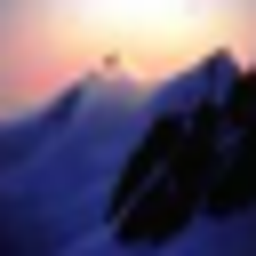

In [34]:
with open(f'{cifar100_path}/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')
with open(f'{cifar100_path}/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

CLASSES = [28, 24, 49]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCHW -> NHWC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test
Image.fromarray(train_X[50]).resize((256,256))

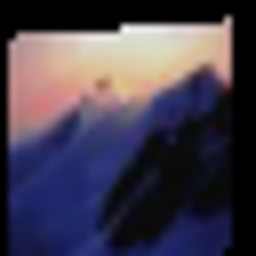

In [35]:
class CifarDataset(Dataset):
     def __init__(self, X, y, transform=None, p=0.0):
         assert X.size(0) == y.size(0)
         super(Dataset, self).__init__()
         self.X = X
         self.y = y
         self.transform = transform
         self.prob = p
        
     def __len__(self):
         return self.y.size(0)
        
     def __getitem__(self, index):
        x = self.X[index]
        if self.transform and np.random.random()<self.prob:
            x = self.transform(x.permute(2, 0, 1)/255.).permute(1, 2, 0)*255.
        y = self.y[index]
        return x, y

transform = T.Compose([
     T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.0),
     T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2),
                    shear=5),
])

Image.fromarray((transform(torch.Tensor(train_X[50]).permute(2, 0, 1)/255.).\
                 permute(1, 2, 0).numpy()*255.).astype(np.uint8)).\
                 resize((256, 256))
                

In [41]:
batch_size = 128
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = CifarDataset(tensor_x, tensor_y,
                           transform if part=='train' else None,
                           p=0.5) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size,
                                  prefetch_factor=8 if part=='train' else 2,
                                  num_workers=2, persistent_workers=True,
                                  shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x2a47ce040>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x2a42727c0>}

In [42]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        #x = torch.mean(x, axis=-1)
        return torch.flatten(x, start_dim=1) # nhw -> nm

class Cifar100_AE(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_AE, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.norm = Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025])
        self.encoder = nn.Sequential(
            nn.Linear(32*32*3, hidden_size),
            nn.ELU(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ELU(),
            nn.Linear(hidden_size//2, hidden_size//8),
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size//8, hidden_size//2),
            nn.ELU(),
            nn.Linear(hidden_size//2, hidden_size),
            nn.ELU(),
            nn.Linear(hidden_size, 32*32*3),
        )

    def forward(self, input):
        normed = self.norm(input)
        encoded = self.encoder(normed)
        out = self.decoder(encoded)
        return out, encoded, normed

HIDDEN_SIZE = 512
model = Cifar100_AE(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
model.to(device)

Cifar100_AE(
  (norm): Normalize()
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=512, out_features=3072, bias=True)
  )
)

In [43]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [46]:
EPOCHS = 200
REDRAW_EVERY = 20
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
# NEW
pbar = tqdm(total=EPOCHS*steps_per_epoch)
losses = []
losses_val = []
passed = 0
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    #running_loss = 0.0
    tmp = []
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, _ = batch
        # # на GPU
        # inputs, _ = inputs.to(device), _.to(device)

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs[0], outputs[2])
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        accuracy = r2_score(outputs[2].detach().cpu().numpy(),
                            outputs[0].detach().cpu().numpy())*100
        tmp.append((loss.item(), accuracy.item()))
        pbar.update(1)
    losses.append((np.mean(tmp, axis=0),
                   np.percentile(tmp, 25, axis=0),
                   np.percentile(tmp, 75, axis=0)))
    tmp = []
    model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, _ = data
            # # на GPU
            # inputs, _ = inputs.to(device), _.to(device)

            outputs = model(inputs)
            loss = criterion(outputs[0], outputs[2])
            accuracy = r2_score(outputs[2].detach().cpu().numpy(),
                            outputs[0].detach().cpu().numpy())*100
            tmp.append((loss.item(), accuracy.item()))
    #print(f'[{epoch + 1}, {i + 1:5d}] val loss: {running_loss / steps_per_epoch_val:.3f}')
    losses_val.append((np.mean(tmp, axis=0),
                       np.percentile(tmp, 25, axis=0),
                       np.percentile(tmp, 75, axis=0)))
    if (epoch+1) % REDRAW_EVERY != 0:
        continue
    clear_output(wait=False)
    passed += pbar.format_dict['elapsed']
    pbar = tqdm(total=EPOCHS*steps_per_epoch, miniters=5)
    pbar.update((epoch+1)*steps_per_epoch)
    x_vals = np.arange(epoch+1)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    stats = np.array(losses)
    stats_val = np.array(losses_val)
    ax[1].set_ylim(stats_val[:, 0, 1].min()-5, 100)
    ax[1].grid(axis='y')
    for i, title in enumerate(['CCE', 'Accuracy']):
        ax[i].plot(x_vals, stats[:, 0, i], label='train')
        ax[i].fill_between(x_vals, stats[:, 1, i],
                           stats[:, 2, i], alpha=0.4)
        ax[i].plot(x_vals, stats_val[:, 0, i], label='val')
        ax[i].fill_between(x_vals,
                           stats_val[:, 1, i],
                           stats_val[:, 2, i], alpha=0.4)
        ax[i].legend()
        ax[i].set_title(title)
    plt.show()
print('Обучение закончено за %s секунд' % passed)

  0%|          | 0/2400 [00:00<?, ?it/s]

RuntimeError: DataLoader worker (pid(s) 89856, 89857) exited unexpectedly

## Часть 2